In [2]:
import sys

import torch
import matplotlib.pyplot as plt

import time

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import numpy as np
import tqdm

from torch.utils.data import DataLoader
from torch import optim

In [3]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [4]:
print("epoch와 batch size를 지정해줍니다.")
_epoch = 30
batch_size = 128

epoch와 batch size를 지정해줍니다.


In [5]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

In [6]:
print("File Download : CIFAR10 dataset")

train_dataset = dsets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_dataset = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

File Download : CIFAR10 dataset


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


1번 모델 : CNN (실습 시간에 사용한 코드 활용)

In [7]:
class my_CNN(nn.Module):
    def __init__(self):
        super(my_CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=2)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 64*4*4)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [8]:
net1 = my_CNN()
net1 = net1.to(device)
criterion = nn.CrossEntropyLoss()

In [9]:
train_loss_history_myCNN = []
val_loss_history_myCNN = []
train_acc_history_myCNN = []
val_acc_history_myCNN = []

In [10]:
lr = 0.1
optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(_epoch * 0.5), int(_epoch * 0.05)], gamma=0.1, last_epoch=-1)

In [11]:
print("Training Start : First model (my_CNN)")
start = time.time()

for epoch in range(_epoch):  
    lr_scheduler.step()
    
    avg_cost = 0.0
    train_loss = 0.0
    train_total = 0.0


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss += loss.item()
        train_total += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    avg_cost /= batch_size
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)
    

    with torch.no_grad():
        val_loss = 0.0
        total = 0
        for val_step, val in enumerate(val_loader):
            val_x, val_label = val
            
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = net1(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(epoch+1, _epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history_myCNN.append(train_loss)
    train_acc_history_myCNN.append(train_acc)     
    val_loss_history_myCNN .append(val_loss)
    val_acc_history_myCNN.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Training Start : First model (my_CNN)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 1/30 | train loss: 4.049068611296241 | val loss: 1.7843070030212402
train acc : 0.21262
val_acc: 0.2909
epoch: 2/30 | train loss: 3.439584992425826 | val loss: 1.657216191291809
train acc : 0.31554
val_acc: 0.3356
epoch: 3/30 | train loss: 3.2133447111720015 | val loss: 1.5563328266143799
train acc : 0.37932
val_acc: 0.4068
epoch: 4/30 | train loss: 3.012904434252883 | val loss: 1.4853856563568115
train acc : 0.43096
val_acc: 0.4324
epoch: 5/30 | train loss: 2.849987397108541 | val loss: 1.3600926399230957
train acc : 0.46828
val_acc: 0.4965
epoch: 6/30 | train loss: 2.710583513655016 | val loss: 1.3140246868133545
train acc : 0.50204
val_acc: 0.5276
epoch: 7/30 | train loss: 2.613028227520721 | val loss: 1.2628493309020996
train acc : 0.52796
val_acc: 0.5439
epoch: 8/30 | train loss: 2.51473925546612 | val loss: 1.2776647806167603
train acc : 0.54912
val_acc: 0.547
epoch: 9/30 | train loss: 2.425020258444959 | val loss: 1.2151488065719604
train acc : 0.56834
val_acc: 0.5681
epo

In [12]:
print("Test Start : First model (my_CNN)")

start = time.time()
correct = 0.0
total = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net1(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end = time.time()
t = int(end-start)
print("Test time: %dm %ds" %(t//60, t%60))
print("Test Finished")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start : First model (my_CNN)
Test time: 0m 2s
Test Finished
Accuracy of the network on the 10000 test images: 65.0 %


Show Loss plot : First model


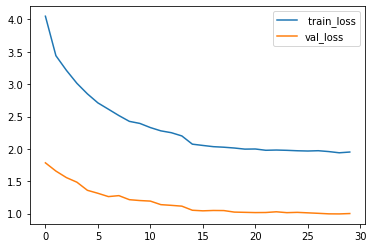

In [13]:
print("Show Loss plot : First model")

plt.plot(train_loss_history_myCNN, label = ' train_loss')
val_loss_history = [i.cpu() for i in val_loss_history_myCNN]
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot : First model


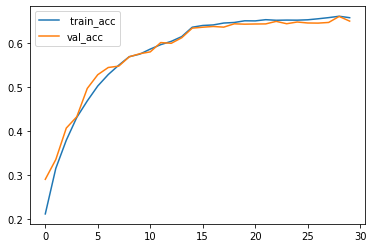

In [14]:
print("Show Acc plot : First model")

plt.plot(train_acc_history_myCNN, label = ' train_acc')
plt.plot(val_acc_history_myCNN, label = 'val_acc')
plt.legend()
plt.show()

2번 모델 : ResNet

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1: # When Downsampling,
            self.downsample = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, 3, 2, 1),
                                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.relu(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x = self.downsample(x)
        out += x
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = []
        for _ in range(n):
            self.layer1.append(ResidualBlock(16, 16, 1))
        self.layer2 = [ResidualBlock(16, 32, 2)]
        for _ in range(n-1):
            self.layer2.append(ResidualBlock(32, 32, 1))
        self.layer3 = [ResidualBlock(32, 64, 2)]
        for _ in range(n-1):
            self.layer3.append(ResidualBlock(64, 64, 1))
        
        self.layer1 = nn.Sequential(*self.layer1)
        self.layer2 = nn.Sequential(*self.layer2)
        self.layer3 = nn.Sequential(*self.layer3)

        self.pool = nn.AvgPool2d(8)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [16]:
net2 = ResNet(3)
net2 = net2.to(device)
criterion = nn.CrossEntropyLoss()

In [17]:
train_loss_history_ResNet = []
val_loss_history_ResNet = []
train_acc_history_ResNet = []
val_acc_history_ResNet = []

In [18]:
lr = 0.1
optimizer = optim.SGD(net2.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(_epoch * 0.5), int(_epoch * 0.05)], gamma=0.1, last_epoch=-1)

In [19]:
print("Training Start : Second model (ResNet)")
start = time.time()

for epoch in range(_epoch):  
    lr_scheduler.step()
    
    avg_cost = 0.0
    train_loss = 0.0
    train_total = 0.0


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss += loss.item()
        train_total += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    avg_cost /= batch_size
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)


    with torch.no_grad():
        val_loss = 0.0
        total = 0
        for val_step, val in enumerate(val_loader):
            val_x, val_label = val
            
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = net2(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(epoch+1, _epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history_ResNet.append(train_loss)
    train_acc_history_ResNet.append(train_acc)     
    val_loss_history_ResNet .append(val_loss)
    val_acc_history_ResNet.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Training Start : Second model (ResNet)
epoch: 1/30 | train loss: 3.0706167379608544 | val loss: 1.2111109495162964
train acc : 0.42822
val_acc: 0.5605
epoch: 2/30 | train loss: 2.130186243435306 | val loss: 0.977546215057373
train acc : 0.61508
val_acc: 0.6501
epoch: 3/30 | train loss: 1.7400294749633125 | val loss: 0.822436511516571
train acc : 0.689
val_acc: 0.7116
epoch: 4/30 | train loss: 1.50214685290061 | val loss: 0.7091209292411804
train acc : 0.73496
val_acc: 0.7482
epoch: 5/30 | train loss: 1.3325617846930424 | val loss: 0.674186110496521
train acc : 0.7657
val_acc: 0.7647
epoch: 6/30 | train loss: 1.2385271252573604 | val loss: 0.6515331268310547
train acc : 0.78276
val_acc: 0.7726
epoch: 7/30 | train loss: 1.1453178052402213 | val loss: 0.5983988046646118
train acc : 0.80162
val_acc: 0.7937
epoch: 8/30 | train loss: 1.0741648675535647 | val loss: 0.5643531680107117
train acc : 0.8125
val_acc: 0.8049
epoch: 9/30 | train loss: 1.020241820598807 | val loss: 0.5532408952713013


In [20]:
print("Test Start : Second model (ResNet)")

start = time.time()
correct = 0.0
total = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net2(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end = time.time()
t = int(end-start)
print("Test time: %dm %ds" %(t//60, t%60))
print("Test Finished")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start : Second model (ResNet)
Test time: 0m 2s
Test Finished
Accuracy of the network on the 10000 test images: 86.0 %


Show Loss plot : Second model


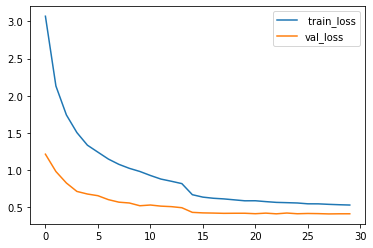

In [21]:
print("Show Loss plot : Second model")

plt.plot(train_loss_history_ResNet, label = ' train_loss')
val_loss_history_ResNet = [i.cpu() for i in val_loss_history_ResNet]
plt.plot(val_loss_history_ResNet, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot : Second model


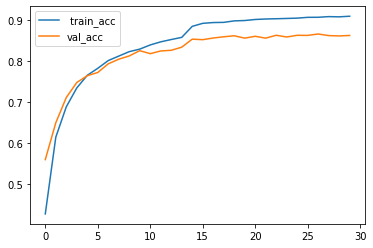

In [22]:
print("Show Acc plot : Second model")

plt.plot(train_acc_history_ResNet, label = ' train_acc')
plt.plot(val_acc_history_ResNet, label = 'val_acc')
plt.legend()
plt.show()

3번 모델 : DenseNet
https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/densenet.py

In [23]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and
        #we refer to our network with such a bottleneck layer, i.e.,
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments
        #consist of a batch normalization layer and an 1×1
        #convolutional layer followed by a 2×2 average pooling
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution
        #with 16 (or twice the growth rate for DenseNet-BC)
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each
        #side of the inputs is zero-padded by one pixel to keep
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

In [24]:
net3 = densenet121()
net3 = net3.to(device)
criterion = nn.CrossEntropyLoss()

In [25]:
train_loss_history_DenseNet = []
val_loss_history_DenseNet = []
train_acc_history_DenseNet = []
val_acc_history_DenseNet = []

In [26]:
lr = 0.1
optimizer = optim.SGD(net3.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(_epoch * 0.5), int(_epoch * 0.05)], gamma=0.1, last_epoch=-1)

In [27]:
print("Training Start : Third model (DenseNet)")
start = time.time()

for epoch in range(_epoch):  
    lr_scheduler.step()
    
    avg_cost = 0.0
    train_loss = 0.0
    train_total = 0.0


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss += loss.item()
        train_total += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    avg_cost /= batch_size
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)


    with torch.no_grad():
        val_loss = 0.0
        total = 0
        for val_step, val in enumerate(val_loader):
            val_x, val_label = val
            
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = net3(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(epoch+1, _epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history_DenseNet.append(train_loss)
    train_acc_history_DenseNet.append(train_acc)     
    val_loss_history_DenseNet .append(val_loss)
    val_acc_history_DenseNet.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Training Start : Third model (DenseNet)
epoch: 1/30 | train loss: 2.719623986412497 | val loss: 1.0195538997650146
train acc : 0.51504
val_acc: 0.6324
epoch: 2/30 | train loss: 1.7210699222276888 | val loss: 0.7752498984336853
train acc : 0.69856
val_acc: 0.7272
epoch: 3/30 | train loss: 1.3013222889827036 | val loss: 0.6197905540466309
train acc : 0.77304
val_acc: 0.789
epoch: 4/30 | train loss: 1.0716396341543368 | val loss: 0.5388684272766113
train acc : 0.81504
val_acc: 0.8144
epoch: 5/30 | train loss: 0.9152273517435469 | val loss: 0.5208014845848083
train acc : 0.84104
val_acc: 0.8242
epoch: 6/30 | train loss: 0.7994932882926044 | val loss: 0.4721119701862335
train acc : 0.86134
val_acc: 0.8415
epoch: 7/30 | train loss: 0.7167796827185794 | val loss: 0.4265107810497284
train acc : 0.87608
val_acc: 0.8531
epoch: 8/30 | train loss: 0.64621526109593 | val loss: 0.41236579418182373
train acc : 0.8894
val_acc: 0.8635
epoch: 9/30 | train loss: 0.5703648835649271 | val loss: 0.372136890

In [28]:
print("Test Start : Third model (DenseNet)")

start = time.time()
correct = 0.0
total = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net3(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end = time.time()
t = int(end-start)
print("Test time: %dm %ds" %(t//60, t%60))
print("Test Finished")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start : Third model (DenseNet)
Test time: 0m 10s
Test Finished
Accuracy of the network on the 10000 test images: 91.0 %


Show Loss plot : Third model


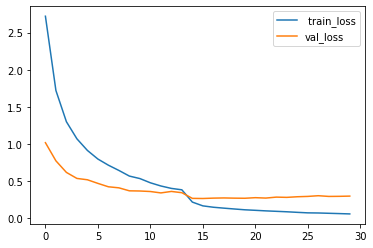

In [29]:
print("Show Loss plot : Third model")

plt.plot(train_loss_history_DenseNet, label = ' train_loss')
val_loss_history_DenseNet = [i.cpu() for i in val_loss_history_DenseNet]
plt.plot(val_loss_history_DenseNet, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot : Third model


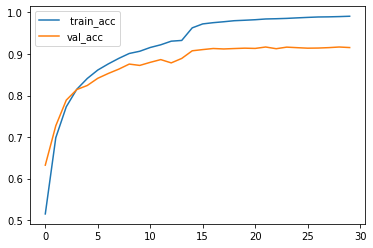

In [30]:
print("Show Acc plot : Third model")

plt.plot(train_acc_history_DenseNet, label = ' train_acc')
plt.plot(val_acc_history_DenseNet, label = 'val_acc')
plt.legend()
plt.show()

In [31]:
print("Train All Models!!!")

Train All Models!!!


Compare : three models val_acc


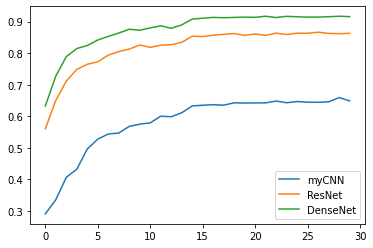

In [32]:
print("Compare : three models val_acc")

plt.plot(val_acc_history_myCNN, label = 'myCNN')
plt.plot(val_acc_history_ResNet, label = 'ResNet')
plt.plot(val_acc_history_DenseNet, label = 'DenseNet')
plt.legend()
plt.show()

Compare : three models val_loss


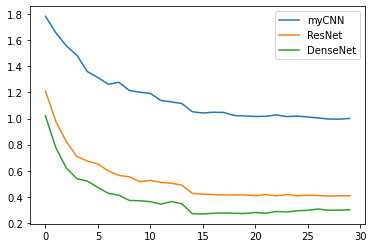

In [35]:
print("Compare : three models val_loss")

val_loss_history_myCNN = [i.cpu() for i in val_loss_history_myCNN]
plt.plot(val_loss_history_myCNN, label = 'myCNN')
val_loss_history_ResNet = [i.cpu() for i in val_loss_history_ResNet]
plt.plot(val_loss_history_ResNet, label = 'ResNet')
val_loss_history_DenseNet = [i.cpu() for i in val_loss_history_DenseNet]
plt.plot(val_loss_history_DenseNet, label = 'DenseNet')
plt.legend()
plt.show()